In [1]:
import numpy as np 
import pandas as pd

# Tensorflow - Help Protect the Great Barrier Reef
## The dataset

In [2]:
testcsv=pd.read_csv('../input/tensorflow-great-barrier-reef/test.csv')
traincsv=pd.read_csv('../input/tensorflow-great-barrier-reef/train.csv')

In [3]:
print('We have %s total images of coral reef'%len(traincsv))

We have 23501 total images of coral reef


In [4]:
import cv2
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
import os
from torchvision import datasets
from sklearn.model_selection import train_test_split

### Train DF Pandas setting

In [5]:
gpath = "../input/tensorflow-great-barrier-reef/train_images/"

In [6]:
traincsv['path']=gpath+'video_'+traincsv['video_id'].astype(str)+'/'+traincsv['video_frame'].astype(str)+'.jpg'
traincsv.head()

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,path
0,0,40258,0,0,0-0,[],../input/tensorflow-great-barrier-reef/train_i...
1,0,40258,1,1,0-1,[],../input/tensorflow-great-barrier-reef/train_i...
2,0,40258,2,2,0-2,[],../input/tensorflow-great-barrier-reef/train_i...
3,0,40258,3,3,0-3,[],../input/tensorflow-great-barrier-reef/train_i...
4,0,40258,4,4,0-4,[],../input/tensorflow-great-barrier-reef/train_i...


Now that I am done with introducing paths I'll now likely form a dataset.

I will also use introduce some columns with x, y, width and height paramters

In [7]:
for i in range(len(traincsv)):
    traincsv['annotations'][i]=eval(traincsv['annotations'][i])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [8]:
traincsv['x']=np.NaN
traincsv['y']=np.NaN
traincsv['width']=np.NaN
traincsv['height']=np.NaN

In [9]:
traincsv.head()

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,path,x,y,width,height
0,0,40258,0,0,0-0,[],../input/tensorflow-great-barrier-reef/train_i...,NaN,NaN,NaN,NaN
1,0,40258,1,1,0-1,[],../input/tensorflow-great-barrier-reef/train_i...,NaN,NaN,NaN,NaN
2,0,40258,2,2,0-2,[],../input/tensorflow-great-barrier-reef/train_i...,NaN,NaN,NaN,NaN
3,0,40258,3,3,0-3,[],../input/tensorflow-great-barrier-reef/train_i...,NaN,NaN,NaN,NaN
4,0,40258,4,4,0-4,[],../input/tensorflow-great-barrier-reef/train_i...,NaN,NaN,NaN,NaN


In [10]:
for i in range(len(traincsv)):
    if traincsv.annotations[i]!=[]:
        traincsv['x'][i]=traincsv.annotations[i][0]['x']
        traincsv['y'][i]=traincsv.annotations[i][0]['y']
        traincsv['width'][i]=traincsv.annotations[i][0]['width']
        traincsv['height'][i]=traincsv.annotations[i][0]['height']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

Let's look at the dataframe traincsv now it should have different columns for x,y,width and height with their values.

In [11]:
traincsv.iloc[23:24,:]

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,path,x,y,width,height
23,0,40258,23,23,0-23,"[{'x': 535, 'y': 207, 'width': 58, 'height': 48}]",../input/tensorflow-great-barrier-reef/train_i...,535.0,207.0,58.0,48.0


Hurray! Its their where we exactly wanted it to be.

Let's now look at an image. Our first one. It's actually a BGR image. So we'll convert into RGB and then view. But before this, let us define a function to return a reactangle based on x,y,width, and height along with the image with bounding box

In [12]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[0], bb[1]), bb[2], bb[3], color=color,
                         fill=False, lw=3)
def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

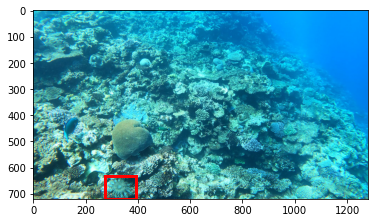

In [13]:
k=100
img = cv2.imread(traincsv.path[k])
im = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
show_corner_bb(im,[traincsv.x[k],traincsv.y[k],traincsv.width[k],traincsv.height[k]])

We can now see the images with bounding boxes of starfish in coral images.

In [14]:
# We are going to drop nas because they wont yield us anything
traincsv.dropna(inplace=True)
traincsv.index=list(range(len(traincsv)))

In [15]:
print("We now have %d images which actually have bounding boxes defined."%len(traincsv))

We now have 4919 images which actually have bounding boxes defined.


In [16]:
traincsv.head()

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,path,x,y,width,height
0,0,40258,16,16,0-16,"[{'x': 559, 'y': 213, 'width': 50, 'height': 32}]",../input/tensorflow-great-barrier-reef/train_i...,559.0,213.0,50.0,32.0
1,0,40258,17,17,0-17,"[{'x': 558, 'y': 213, 'width': 50, 'height': 32}]",../input/tensorflow-great-barrier-reef/train_i...,558.0,213.0,50.0,32.0
2,0,40258,18,18,0-18,"[{'x': 557, 'y': 213, 'width': 50, 'height': 32}]",../input/tensorflow-great-barrier-reef/train_i...,557.0,213.0,50.0,32.0
3,0,40258,19,19,0-19,"[{'x': 556, 'y': 214, 'width': 50, 'height': 32}]",../input/tensorflow-great-barrier-reef/train_i...,556.0,214.0,50.0,32.0
4,0,40258,20,20,0-20,"[{'x': 555, 'y': 214, 'width': 50, 'height': 32}]",../input/tensorflow-great-barrier-reef/train_i...,555.0,214.0,50.0,32.0


Now let us define x of this dataset

In [17]:
traincsv['annots']='0'
for i in range(len(traincsv)):
    traincsv.at[i,'annots']=list([traincsv.x[i],traincsv.y[i],traincsv.x[i]+traincsv.width[i],traincsv.y[i]+traincsv.height[i]])

In [18]:
#x=cv2.imread(traincsv.path[0]).astype(np.float32)
#x=cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255

We wont define the dataset as image array but only path array to save memory

In [19]:
x,y=traincsv['path'],traincsv['annots']

In [20]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

In [21]:
print("We now have %d train sets and %d test sets from a total of %d sets."%(len(x_train),len(x_val),len(traincsv)))

We now have 3935 train sets and 984 test sets from a total of 4919 sets.


We will use data transforms for editing our images

In [22]:
transform = transforms.Compose(
    [transforms.ToTensor()])

In [23]:
batch_size = 64
num_workers= 0

In [24]:
import torch.optim as optim
import torch.nn as nn
#criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [25]:
traincsv.head()

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,path,x,y,width,height,annots
0,0,40258,16,16,0-16,"[{'x': 559, 'y': 213, 'width': 50, 'height': 32}]",../input/tensorflow-great-barrier-reef/train_i...,559.0,213.0,50.0,32.0,"[559.0, 213.0, 609.0, 245.0]"
1,0,40258,17,17,0-17,"[{'x': 558, 'y': 213, 'width': 50, 'height': 32}]",../input/tensorflow-great-barrier-reef/train_i...,558.0,213.0,50.0,32.0,"[558.0, 213.0, 608.0, 245.0]"
2,0,40258,18,18,0-18,"[{'x': 557, 'y': 213, 'width': 50, 'height': 32}]",../input/tensorflow-great-barrier-reef/train_i...,557.0,213.0,50.0,32.0,"[557.0, 213.0, 607.0, 245.0]"
3,0,40258,19,19,0-19,"[{'x': 556, 'y': 214, 'width': 50, 'height': 32}]",../input/tensorflow-great-barrier-reef/train_i...,556.0,214.0,50.0,32.0,"[556.0, 214.0, 606.0, 246.0]"
4,0,40258,20,20,0-20,"[{'x': 555, 'y': 214, 'width': 50, 'height': 32}]",../input/tensorflow-great-barrier-reef/train_i...,555.0,214.0,50.0,32.0,"[555.0, 214.0, 605.0, 246.0]"


In [26]:
from PIL import Image
import time
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self):
        self.imgs = list(x)
        
    def __getitem__(self, idx):
        # load images and masks
        img_path = self.imgs[idx]
        img = Image.open(img_path).convert("RGB")

        # get bounding box coordinates for each mask
        boxes = y[idx]
        n_objects=len(y)
        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        boxes=boxes.reshape((1,4))
        # there is only one class
        labels = torch.ones((n_objects,), dtype=torch.int64)
        area = (boxes[:,3] - boxes[:,1]) * (boxes[:,2] - boxes[:,0])
        iscrowd = torch.zeros((n_objects,), dtype=torch.int64)
        image_id = torch.tensor([idx])
        
        target = {}
        target["boxes"] = boxes
        target["area"] = area
        target["labels"]=labels
        target['image_id']=image_id
        target['iscrowd']=iscrowd
        img = transform(img)

        return img, target
    def __len__(self):
        return len(self.imgs)
dataset = PennFudanDataset()
dataset[1]

(tensor([[[0.1882, 0.1608, 0.1490,  ..., 0.0000, 0.0000, 0.0000],
          [0.2745, 0.2314, 0.1686,  ..., 0.0000, 0.0000, 0.0000],
          [0.2706, 0.2510, 0.2000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.7059, 0.5647, 0.5294,  ..., 0.0784, 0.0667, 0.0431],
          [0.6000, 0.5333, 0.5608,  ..., 0.1725, 0.1216, 0.0980],
          [0.5725, 0.5373, 0.5765,  ..., 0.1922, 0.1725, 0.1020]],
 
         [[0.6941, 0.6235, 0.6157,  ..., 0.5922, 0.5922, 0.5882],
          [0.8196, 0.7412, 0.6706,  ..., 0.5922, 0.5922, 0.5882],
          [0.8353, 0.8078, 0.7608,  ..., 0.5922, 0.5922, 0.5882],
          ...,
          [0.8196, 0.7608, 0.8235,  ..., 0.8078, 0.7922, 0.7647],
          [0.7216, 0.7529, 0.8627,  ..., 0.8353, 0.8196, 0.8431],
          [0.7294, 0.8039, 0.9020,  ..., 0.7882, 0.8392, 0.8510]],
 
         [[0.9490, 0.8745, 0.8745,  ..., 0.9961, 0.9961, 0.9922],
          [0.9804, 0.9765, 0.9490,  ..., 0.9961, 0.9961, 0.9922],
          [0.9804, 0.9882, 0.9882,  ...,

In [27]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [28]:
import torch.functional as F
from torch import Tensor
from typing import Tuple, List, Optional, Dict


class ToTensor:
    def __call__(self, pic):
        return F.to_tensor(pic)
    def __repr__(self):
        return self.__class__.__name__ + "()"

class ToTensor(nn.Module):
    def forward(
        self, image: Tensor, target: Optional[Dict[str, Tensor]] = None
    ) -> Tuple[Tensor, Optional[Dict[str, Tensor]]]:
        image = F.pil_to_tensor(image)
        image = F.convert_image_dtype(image)
        return image, target
    
class RandomHorizontalFlip(torch.nn.Module):
    def __init__(self, p=0.5):
        super().__init__()
        self.p = p

    def forward(self, img):
        if torch.rand(1) < self.p:
            return F.hflip(img)
        return img

    def __repr__(self):
        return self.__class__.__name__ + f"(p={self.p})"
    
class RandomHorizontalFlip(RandomHorizontalFlip):
    def forward(
        self, image: Tensor, target: Optional[Dict[str, Tensor]] = None
    ) -> Tuple[Tensor, Optional[Dict[str, Tensor]]]:
        if torch.rand(1) < self.p:
            image = F.hflip(image)
            if target is not None:
                width, _ = F.get_image_size(image)
                target["boxes"][:, [0, 2]] = width - target["boxes"][:, [2, 0]]
                if "masks" in target:
                    target["masks"] = target["masks"].flip(-1)
                if "keypoints" in target:
                    keypoints = target["keypoints"]
                    keypoints = _flip_coco_person_keypoints(keypoints, width)
                    target["keypoints"] = keypoints
        return image, target

class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img):
        for t in self.transforms:
            img = t(img)
        return img

    def __repr__(self):
        format_string = self.__class__.__name__ + "("
        for t in self.transforms:
            format_string += "\n"
            format_string += f"    {t}"
        format_string += "\n)"
        return format_string
    
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(ToTensor())
    if train:
        transforms.append(RandomHorizontalFlip(0.5))
    return Compose(transforms)

Finetuning a pretrained model

In [29]:
model =  torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [30]:
in_features = model.roi_heads.box_predictor.cls_score.in_features   
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)
model.to(DEVICE)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [31]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, weight_decay=0.0005, momentum = 0.9)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.85)

In [32]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    train_loss = []
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Train ')
    for step, (images, targets) in pbar:
        images=images.reshape(shape=(1,3,720,1280))
        images = list(images.to(device))
        targets = [{k: v.to(DEVICE) for k, v in targets.items()}] 
        t=targets
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        train_loss.append(losses.item())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        scheduler.step()    
    mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
    torch.cuda.empty_cache()
    gc.collect()
    return np.mean(train_loss)

In [33]:
import time
def run_training(model, optimizer, scheduler, device, num_epochs):
    if torch.cuda.is_available():
        print("cuda: {}\n".format(torch.cuda.get_device_name()))
    start = time.time()
    history = {}
    best_loss = np.inf
    best_epoch = -1
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        print(f'Epoch {epoch}/{num_epochs}', end='')
        train_loss = train_one_epoch(model, optimizer, scheduler,dataloader=dataset, device=DEVICE, epoch=epoch)
        if len(history) == 0:
            history['train_loss'] = [train_loss]
        else:
            history['train_loss'].append(train_loss)
        if train_loss <= best_loss:
            best_loss = train_loss
            best_epoch = epoch
        # deep copy the model
        PATH = f"best_epoch-{epoch:02d}.bin"
        print(PATH)
        torch.save(model.state_dict(), PATH)
        # Save a model file from the current directory
        print(f"Model Saved")
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Score: {:.4f}".format(best_loss))
    print("Best Epoch: {:3d}".format(best_epoch))
    return model, history

In [35]:
DEBUG = False
import gc
from tqdm import tqdm
model, history = run_training(model, optimizer, lr_scheduler,device=DEVICE, num_epochs=3)

cuda: Tesla P100-PCIE-16GB

Epoch 1/1

Train : 100%|██████████| 4919/4919 [14:35<00:00,  5.62it/s]


NameError: name 'val_loss' is not defined

In [38]:
PATH = f"best_epoch.bin"
torch.save(model.state_dict(), PATH)

In [39]:
torch.save(model,'great-barrier-reef-model.pth')

In [40]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(